In [7]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from collections import Counter
from wordcloud import WordCloud
import gensim
from gensim.utils import simple_preprocess
from sklearn.model_selection import train_test_split
import spacy
import pickle
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
import tensorflow as tf
import keras
import numpy as np
import pandas as pd

In [8]:
DATASET_COLUMNS = ["target","ids","date","flag","user","text"]
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv("Datasets/training.1600000.processed.noemoticon.csv",encoding=DATASET_ENCODING, names = DATASET_COLUMNS)
df.sample(5)

,target,ids,date,flag,user,text
1385483,4,2052752838,Sat Jun 06 01:53:22 PDT 2009,NO_QUERY,tonyvirtual,How do you like my outfit? Looking good?
657684,0,2241121485,Fri Jun 19 10:33:58 PDT 2009,NO_QUERY,rudyx760,Wish i lived in Santa Monica to go to the &quo...
410415,0,2059872092,Sat Jun 06 17:48:25 PDT 2009,NO_QUERY,cfierce,"@Hope_Isabel nothinggg, just wokeee up and I'm..."
1244414,4,1994806104,Mon Jun 01 12:29:17 PDT 2009,NO_QUERY,danbraithwaite,Downloading flash catalyst beta
1494505,4,2069713004,Sun Jun 07 16:23:21 PDT 2009,NO_QUERY,thebeanboy23,@Squibby_ twas good. Freakshow and womanizer h...


In [9]:
len(df)

1600000

In [10]:
np.sum(df.isnull().any(axis=1))

0

In [11]:
df["target"].unique()

array([0, 4], dtype=int64)

In [12]:
df.groupby("target").nunique()

,ids,date,flag,user,text
target,,,,,
0,800000,593879,1,415671,790185
4,800000,286578,1,376569,793506


## Data Preprocessing

In [13]:
train=df[["text","target"]]

In [14]:
train.head()

,text,target
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


In [15]:
train["target"]= train["target"].replace(4,1) 

In [16]:
train["target"][-5:-1]

1599995    1
1599996    1
1599997    1
1599998    1
Name: target, dtype: int64

In [17]:
train["target"].unique()

array([0, 1], dtype=int64)

In [18]:
data_pos = train[train["target"]==1] 
data_neg = train[train["target"]==0]

In [19]:
data_pos = data_pos.iloc[:int(20000)]
data_neg = data_neg.iloc[:int(20000)]

In [20]:
combined = pd.concat([data_pos,data_neg])

In [21]:
combined["text"] = combined["text"].str.lower()
combined["text"].tail()

19995    not much time off this weekend, work trip to m...
19996                            one more day of holidays 
19997    feeling so down right now .. i hate you damn h...
19998    geez,i hv to read the whole book of personalit...
19999    i threw my sign at donnie and he bent over to ...
Name: text, dtype: object

In [22]:
combined["text"].isnull().sum()

0

In [23]:
# if there is any null 
# combined["selected_text"].fillna("No context",inplace=True)

In [24]:
import string
english_punctuations = string.punctuation

def clean_data(data):
    
    #Removing URLs 
    url_pattern = re.compile(r"https?://\S+|www.\.S+")
    data = url_pattern.sub(r"",data)
    
    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)

    # Remove new line characters
    data = re.sub('\s+', ' ', data)

    # Remove distracting single quotes
    data = re.sub("\'", "", data)
    
    translator = str.maketrans(" "," ",english_punctuations)
    data = data.translate(translator)
        
    return data

In [25]:
temp = []
#Splitting pd.Series to list 
text_list = combined["text"].values.tolist()

for i in range(len(text_list)):
    temp.append(clean_data(text_list[i]))
print(temp[:5])


['i love u guys r the best ', 'im meeting up with one of my besties tonight cant wait  girl talk', 'thanks for the twitter add sunisa i got to meet you once at a hin show here in the dc area and you were a sweetheart ', 'being sick can be really cheap when it hurts too much to eat real food plus your friends make you soup', 'he has that effect on everyone ']


In [26]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence),deacc=True)) #deacc=True removes punctuations
        
data_words = list(sent_to_words(temp))
print(data_words[:10])

[['love', 'guys', 'the', 'best'], ['im', 'meeting', 'up', 'with', 'one', 'of', 'my', 'besties', 'tonight', 'cant', 'wait', 'girl', 'talk'], ['thanks', 'for', 'the', 'twitter', 'add', 'sunisa', 'got', 'to', 'meet', 'you', 'once', 'at', 'hin', 'show', 'here', 'in', 'the', 'dc', 'area', 'and', 'you', 'were', 'sweetheart'], ['being', 'sick', 'can', 'be', 'really', 'cheap', 'when', 'it', 'hurts', 'too', 'much', 'to', 'eat', 'real', 'food', 'plus', 'your', 'friends', 'make', 'you', 'soup'], ['he', 'has', 'that', 'effect', 'on', 'everyone'], ['you', 'can', 'tell', 'him', 'that', 'just', 'burst', 'out', 'laughing', 'really', 'loud', 'because', 'of', 'that', 'thanks', 'for', 'making', 'me', 'come', 'out', 'of', 'my', 'sulk'], ['thans', 'for', 'your', 'response', 'ihad', 'already', 'find', 'this', 'answer'], ['am', 'so', 'jealous', 'hope', 'you', 'had', 'great', 'time', 'in', 'vegas', 'how', 'did', 'you', 'like', 'the', 'acms', 'love', 'your', 'show'], ['ah', 'congrats', 'mr', 'fletcher', 'for',

Note:

gensim.utils.simple_preprocess(doc, deacc=False, min_len=2, max_len=15)
    
Convert a document into a list of tokens.

This lowercases, tokenizes, de-accents (optional). – the output are final tokens = unicode strings, that won’t be processed any further.

In [27]:
len(data_words)

40000

In [28]:
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

In [29]:
data = []
for i in range(len(data_words)):
    data.append(detokenize(data_words[i]))
print(data[:5])

['love guys the best', 'im meeting up with one of my besties tonight cant wait girl talk', 'thanks for the twitter add sunisa got to meet you once at hin show here in the dc area and you were sweetheart', 'being sick can be really cheap when it hurts too much to eat real food plus your friends make you soup', 'he has that effect on everyone']


In [30]:
data = np.array(data)

In [31]:
labels = np.array(combined["target"])
labels = tf.keras.utils.to_categorical(labels,2)


In [32]:
len(labels)

40000

In [33]:
labels

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

## Data sequencing and splitting

Transforming text data into 3D fload data via Keras Tokenizer and pad_sequences

In [34]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop,Adam
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint

In [35]:
max_words = 5000
max_len = 200

In [36]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
tweets = pad_sequences(sequences,maxlen=max_len)

pad_sequences: 
This function transforms a list (of length `num_samples`) of sequences (lists of integers) into a 2D Numpy array of shape `(num_samples, num_timesteps)`.

In [37]:
print(tweets)

[[   0    0    0 ...  212    2  172]
 [   0    0    0 ...  138  287  317]
 [   0    0    0 ...    5  125 2888]
 ...
 [   0    0    0 ...  147    5  257]
 [   0    0    0 ...    9    3  469]
 [   0    0    0 ...  482   20   13]]


In [38]:
tweets[:2]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 

In [39]:
print(labels)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [40]:
X_train,X_test,y_train,y_test = train_test_split(tweets,labels,random_state=1000000)
print(len(X_train),len(X_test),len(y_train),len(y_test))

30000 10000 30000 10000


In [41]:
print(X_train)

[[   0    0    0 ...    1  721  153]
 [   0    0    0 ...    1  912   16]
 [   0    0    0 ...    7 2483   92]
 ...
 [   0    0    0 ...  305    1    5]
 [   0    0    0 ...    0    0    4]
 [   0    0    0 ...    5  296 2651]]


In [42]:
print(X_test)

[[   0    0    0 ...  182    9   39]
 [   0    0    0 ...  636    4    7]
 [   0    0    0 ...   22  649  185]
 ...
 [   0    0    0 ...   78   58  302]
 [   0    0    0 ...  452   84  780]
 [   0    0    0 ...  108 1601   59]]


In [43]:
y_train[-10:-1]

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.]])

In [44]:
print(y_test)

[[1. 0.]
 [1. 0.]
 [0. 1.]
 ...
 [0. 1.]
 [1. 0.]
 [0. 1.]]


# Model Building

3 different models has been used:
* Single LSTM layer model
* Bidirectional LSTM model
* 1D convolutional model

## Single LSTM layer Model

In [60]:
model1 = Sequential()
model1.add(layers.Embedding(max_words,20))
model1.add(layers.LSTM(15,dropout=0.5))
model1.add(layers.Dense(2,activation="softmax"))

model1.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
#Creating checkpoints to examination on loss and accruracy
checkpoint1 = ModelCheckpoint("best_model1.keras",monitor="val_accuracy",verbose=1,save_best_only=True,mode="auto",save_weights_only=False)
history = model1.fit(X_train,y_train,epochs=70,validation_data=(X_test,y_test),callbacks=[checkpoint1])

Epoch 1/70
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6373 - loss: 0.6208
Epoch 1: val_accuracy improved from -inf to 0.76240, saving model to best_model1.keras
938/938 ━━━━━━━━━━━━━━━━━━━━ 37s 36ms/step - accuracy: 0.6374 - loss: 0.6206 - val_accuracy: 0.7624 - val_loss: 0.5006
Epoch 2/70
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7865 - loss: 0.4631
Epoch 2: val_accuracy improved from 0.76240 to 0.76920, saving model to best_model1.keras
938/938 ━━━━━━━━━━━━━━━━━━━━ 33s 35ms/step - accuracy: 0.7865 - loss: 0.4631 - val_accuracy: 0.7692 - val_loss: 0.4916
Epoch 3/70
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8005 - loss: 0.4419
Epoch 3: val_accuracy did not improve from 0.76920
938/938 ━━━━━━━━━━━━━━━━━━━━ 35s 37ms/step - accuracy: 0.8005 - loss: 0.4419 - val_accuracy: 0.7683 - val_loss: 0.4937
Epoch 4/70
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8130 - loss: 0.4242
Epoch 4: val_accuracy did not improve from 0.76920
938/938 ━━━━━━━━

Epoch 26/70
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8881 - loss: 0.2663
Epoch 26: val_accuracy did not improve from 0.76920
938/938 ━━━━━━━━━━━━━━━━━━━━ 35s 38ms/step - accuracy: 0.8881 - loss: 0.2664 - val_accuracy: 0.7472 - val_loss: 0.7319
Epoch 27/70
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8919 - loss: 0.2589
Epoch 27: val_accuracy did not improve from 0.76920
938/938 ━━━━━━━━━━━━━━━━━━━━ 35s 38ms/step - accuracy: 0.8919 - loss: 0.2589 - val_accuracy: 0.7452 - val_loss: 0.7352
Epoch 28/70
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8877 - loss: 0.2622
Epoch 28: val_accuracy did not improve from 0.76920
938/938 ━━━━━━━━━━━━━━━━━━━━ 35s 37ms/step - accuracy: 0.8877 - loss: 0.2622 - val_accuracy: 0.7450 - val_loss: 0.7321
Epoch 29/70
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8916 - loss: 0.2595
Epoch 29: val_accuracy did not improve from 0.76920
938/938 ━━━━━━━━━━━━━━━━━━━━ 36s 38ms/step - accuracy: 0.8916 - loss: 0.2595 - val_

## Bidirectional LSTM Model

In [46]:
model2= Sequential()
model2.add(layers.Embedding(max_words,40,input_length=max_len))
model2.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
model2.add(layers.Dense(2,activation="softmax"))

model2.compile(optimizer="adam",loss="categorical_crossentropy",metrics= ["accuracy"] )
#Creating checkpoints to examination on loss and accruracy
checkpoint2= ModelCheckpoint("best_model2.keras",monitor= "val_accuracy",verbose=1,save_best_only=True,mode="auto",save_weights_only=False)
history= model2.fit(X_train,y_train,epochs= 70, validation_data=(X_test,y_test),callbacks=[checkpoint2])

Epoch 1/70
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.6409 - loss: 0.6200
Epoch 1: val_accuracy improved from -inf to 0.76560, saving model to best_model2.keras
938/938 ━━━━━━━━━━━━━━━━━━━━ 67s 66ms/step - accuracy: 0.6410 - loss: 0.6200 - val_accuracy: 0.7656 - val_loss: 0.4928
Epoch 2/70
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7852 - loss: 0.4689
Epoch 2: val_accuracy improved from 0.76560 to 0.77450, saving model to best_model2.keras
938/938 ━━━━━━━━━━━━━━━━━━━━ 60s 64ms/step - accuracy: 0.7852 - loss: 0.4689 - val_accuracy: 0.7745 - val_loss: 0.4795
Epoch 3/70
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8016 - loss: 0.4402
Epoch 3: val_accuracy improved from 0.77450 to 0.77620, saving model to best_model2.keras
938/938 ━━━━━━━━━━━━━━━━━━━━ 60s 64ms/step - accuracy: 0.8016 - loss: 0.4402 - val_accuracy: 0.7762 - val_loss: 0.4789
Epoch 4/70
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8090 - loss: 0.4243
Epoch 4: val_accuracy did no

Epoch 26/70
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8990 - loss: 0.2392
Epoch 26: val_accuracy did not improve from 0.77620
938/938 ━━━━━━━━━━━━━━━━━━━━ 60s 63ms/step - accuracy: 0.8990 - loss: 0.2392 - val_accuracy: 0.7448 - val_loss: 0.7604
Epoch 27/70
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8951 - loss: 0.2443
Epoch 27: val_accuracy did not improve from 0.77620
938/938 ━━━━━━━━━━━━━━━━━━━━ 59s 63ms/step - accuracy: 0.8951 - loss: 0.2443 - val_accuracy: 0.7508 - val_loss: 0.7866
Epoch 28/70
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8964 - loss: 0.2408
Epoch 28: val_accuracy did not improve from 0.77620
938/938 ━━━━━━━━━━━━━━━━━━━━ 60s 64ms/step - accuracy: 0.8964 - loss: 0.2408 - val_accuracy: 0.7485 - val_loss: 0.7889
Epoch 29/70
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9020 - loss: 0.2322
Epoch 29: val_accuracy did not improve from 0.77620
938/938 ━━━━━━━━━━━━━━━━━━━━ 59s 63ms/step - accuracy: 0.9020 - loss: 0.2322 - val_

## 1D Convolutional Model

In [61]:
from keras import regularizers
model3 = Sequential()
model3.add(layers.Embedding(max_words,40,input_length=max_len))
model3.add(layers.Conv1D(20,6,activation="relu",kernel_regularizer = regularizers.l1_l2(l1=2e-3,l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.MaxPooling1D(5))
model3.add(layers.Conv1D(20,6,activation="relu",kernel_regularizer = regularizers.l1_l2(l1=2e-3,l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.GlobalMaxPool1D())
model3.add(layers.Dense(2,activation="softmax"))

model3.compile(optimizer="adam",loss="categorical_crossentropy",metrics= ["accuracy"] )
#Creating checkpoints to examination on loss and accruracy
checkpoint3= ModelCheckpoint("best_model3.keras",monitor= "val_accuracy",verbose=1,save_best_only=True,mode="auto",save_weights_only=False)
history= model3.fit(X_train,y_train,epochs= 70, validation_data=(X_test,y_test),callbacks=[checkpoint3])

Epoch 1/70
931/938 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5049 - loss: 0.9033
Epoch 1: val_accuracy improved from -inf to 0.50480, saving model to best_model3.keras
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5048 - loss: 0.9021 - val_accuracy: 0.5048 - val_loss: 0.6948
Epoch 2/70
925/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5041 - loss: 0.6948
Epoch 2: val_accuracy did not improve from 0.50480
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5040 - loss: 0.6948 - val_accuracy: 0.4952 - val_loss: 0.6949
Epoch 3/70
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5058 - loss: 0.6948
Epoch 3: val_accuracy did not improve from 0.50480
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5058 - loss: 0.6948 - val_accuracy: 0.5048 - val_loss: 0.6948
Epoch 4/70
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5017 - loss: 0.6949
Epoch 4: val_accuracy did not improve from 0.50480
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5017 - los

931/938 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5013 - loss: 0.6949
Epoch 51: val_accuracy did not improve from 0.50480
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5013 - loss: 0.6949 - val_accuracy: 0.4952 - val_loss: 0.6949
Epoch 52/70
929/938 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5036 - loss: 0.6948
Epoch 52: val_accuracy did not improve from 0.50480
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5036 - loss: 0.6948 - val_accuracy: 0.4952 - val_loss: 0.6949
Epoch 53/70
929/938 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5034 - loss: 0.6948
Epoch 53: val_accuracy did not improve from 0.50480
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5034 - loss: 0.6948 - val_accuracy: 0.4952 - val_loss: 0.6949
Epoch 54/70
930/938 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5035 - loss: 0.6949
Epoch 54: val_accuracy did not improve from 0.50480
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5035 - loss: 0.6949 - val_accuracy: 0.5048 - val_l

## Model Evaluation

According to the validation accuracy best fitting model is Bidirectional LSTM

In [45]:
#load best model
best_model = keras.models.load_model("best_model2.keras")

In [46]:
test_loss,test_acc = best_model.evaluate(X_test,y_test,verbose=2)
print("Model Accuracy:",test_acc)

313/313 - 5s - 15ms/step - accuracy: 0.8129 - loss: 0.4181
Model Accuracy: 0.8129000067710876


In [47]:
predictions = best_model.predict(X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


In [48]:
np.around(predictions,decimals=0).argmax(axis=1)

array([0, 0, 1, ..., 1, 0, 0], dtype=int64)

In [49]:
y_test.argmax(axis=1)

array([0, 0, 1, ..., 1, 0, 1], dtype=int64)

## Confusion Matrix

In [50]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test.argmax(axis=1),np.around(predictions,decimals = 0).argmax(axis=1))
#argmax --> returns the indices of the maximum values along an axis

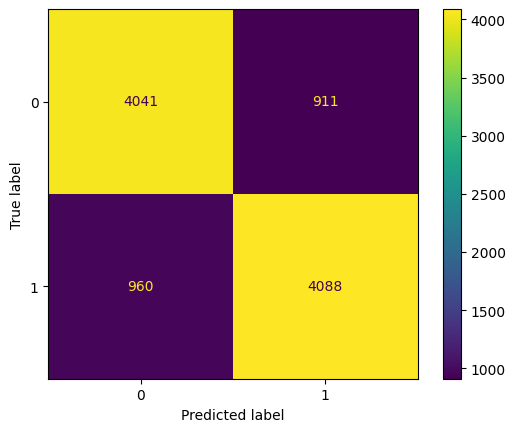

In [51]:
>>> from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=matrix)

disp.plot()
plt.show()

<Axes: >

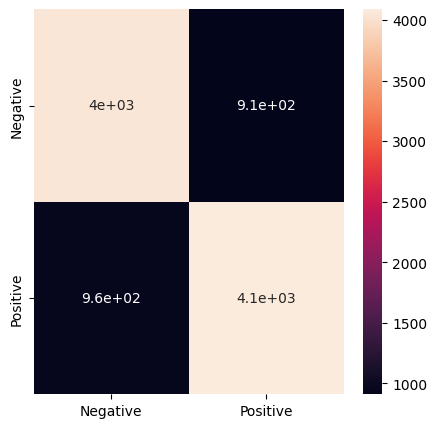

In [52]:
import seaborn as sns
conf_matrix = pd.DataFrame(matrix,index = ["Negative","Positive"],columns = ["Negative","Positive"])
plt.figure(figsize=(5,5))
sns.heatmap(conf_matrix,annot=True,annot_kws={"size":10} )

<Axes: >

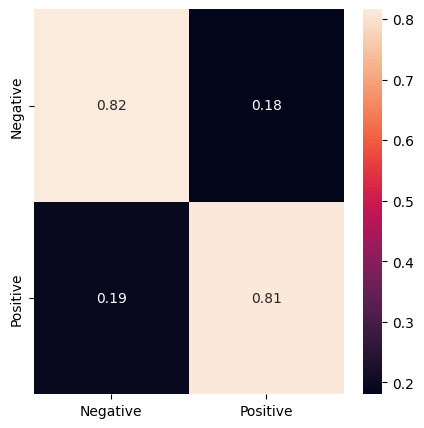

In [53]:
#Normalizing-placing values between 0-1
conf_matrix = conf_matrix.astype("float") / conf_matrix.sum(axis=1)
plt.figure(figsize=(5,5))
sns.heatmap(conf_matrix,annot=True,annot_kws={"size":10} )

In [54]:
sentiment = ["Negative","Positive"]

In [55]:
sequence = tokenizer.texts_to_sequences(["this was the wost experiecen of my life, want my time back"])
test = pad_sequences(sequence,maxlen=max_len)
sentiment[np.around(best_model.predict(test),decimals=0).argmax(axis=1)[0]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


'Negative'

In [56]:
sequence = tokenizer.texts_to_sequences(["one of the best weddings i've ever attended"])
test = pad_sequences(sequence,maxlen=max_len)
sentiment[np.around(best_model.predict(test),decimals=0).argmax(axis=1)[0]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


'Positive'

In [57]:
sequence = tokenizer.texts_to_sequences(["im not thinking about anything right now"])
test = pad_sequences(sequence,maxlen=max_len)
sentiment[np.around(best_model.predict(test),decimals=0).argmax(axis=1)[0]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


'Negative'

In [58]:
sequence = tokenizer.texts_to_sequences(["our team lost, we need to prepare better for the next matches"])
test = pad_sequences(sequence,maxlen=max_len)
sentiment[np.around(best_model.predict(test),decimals=0).argmax(axis=1)[0]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


'Negative'

In [59]:
sequence = tokenizer.texts_to_sequences(["our team gain experience by winning"])
test = pad_sequences(sequence,maxlen=max_len)
sentiment[np.around(best_model.predict(test),decimals=0).argmax(axis=1)[0]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


'Negative'

In [60]:
sequence = tokenizer.texts_to_sequences(["enjoying my life"])
test = pad_sequences(sequence,maxlen=max_len)
sentiment[np.around(best_model.predict(test),decimals=0).argmax(axis=1)[0]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


'Positive'

# Preparing Model for AWS SageMaker

In [ ]:
#Saving weights and tokenizer so we can reduce training time on SageMaker

#serialize model to JSON
model_json = best_model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)

#serialize weights to HDF5
best_model.save_weights("model-weights.h5")
print("Model saved")

#saving tokenizer
with open("tokenizer.pickle","wb") as handle :
    pickle.dump(tokenizer,handle,protocol=pickle.HIGHEST_PROTOCOL)
print("Tokenizer saved")